In [32]:
import numpy as np
import pandas as pd

# Check current directory
import os
print(os.getcwd())

/Users/lesarmstrong/Documents/GitHub/6.C51/sustainable_systems/Final_Project


In [33]:
# Load DAM and RTM .csv
DAM = pd.read_csv('Data_Clean/DAM.csv')
RTM = pd.read_csv('Data_Clean/RTM.csv')

# From RTM take Delivert Date Delivery Hour Delivery Interval and Settlement Point Price columns
RTM = RTM[['Delivery Date', 'Delivery Hour', 'Delivery Interval', 'Settlement Point Price']]

# From DAM take Delivery Date Hour Ending and Settlement Point Price columns
DAM = DAM[['Delivery Date', 'Hour Ending', 'Settlement Point Price']]

from datetime import timedelta
# Function to adjust '24:00' to '00:00' and calculate the interval time
def create_time_intervals_corrected(hour, interval):
    if hour == "24:00":
        hour = "00:00"
    hour_datetime = pd.to_datetime(hour, format='%H:%M')
    interval_time = hour_datetime + timedelta(minutes=(interval - 5) * 15)
    return interval_time.strftime('%H:%M')

# Expand the DAM dataset to account for 15-minute intervals
dam_intervals = pd.DataFrame({"Delivery Interval": range(1, 5)})
DAM['key'] = 1
dam_intervals['key'] = 1
DAM = pd.merge(DAM, dam_intervals, on='key').drop('key', axis=1)

# Create the 'Interval Time' column for DAM
DAM['Interval Time'] = DAM.apply(lambda x: create_time_intervals_corrected(x['Hour Ending'], x['Delivery Interval']), axis=1)

# Prepare the 'Hour Ending' column for RTM to format hours correctly and create 'Interval Time'
RTM['Hour Ending'] = RTM['Delivery Hour'].apply(lambda x: f"{x:02d}:00")
RTM['Interval Time'] = RTM.apply(lambda x: create_time_intervals_corrected(x['Hour Ending'], x['Delivery Interval']), axis=1)

# For both, split up the Delivert Date into 3 columns representing day, month, and year
DAM['Delivery Date'] = pd.to_datetime(DAM['Delivery Date'])
DAM['Year'] = DAM['Delivery Date'].dt.year
DAM['Month'] = DAM['Delivery Date'].dt.month
DAM['Day'] = DAM['Delivery Date'].dt.day

RTM['Delivery Date'] = pd.to_datetime(RTM['Delivery Date'])
RTM['Year'] = RTM['Delivery Date'].dt.year
RTM['Month'] = RTM['Delivery Date'].dt.month
RTM['Day'] = RTM['Delivery Date'].dt.day




In [6]:
RTM

# Print the 10 highest Settlement Point Prices
#print(RTM['Settlement Point Price'].nlargest(10))

,Delivery Date,Delivery Hour,Delivery Interval,Settlement Point Price,Hour Ending,Interval Time,Year,Month,Day
0,2012-01-01,1,1,12.58,01:00,00:00,2012,1,1
1,2012-01-01,1,2,8.83,01:00,00:15,2012,1,1
2,2012-01-01,1,3,13.44,01:00,00:30,2012,1,1
3,2012-01-01,1,4,12.95,01:00,00:45,2012,1,1
4,2012-01-01,2,1,13.22,02:00,01:00,2012,1,1
...,...,...,...,...,...,...,...,...,...
35627,2023-01-31,23,4,39.87,23:00,22:45,2023,1,31
35628,2023-01-31,24,1,41.06,24:00,23:00,2023,1,31
35629,2023-01-31,24,2,41.78,24:00,23:15,2023,1,31
35630,2023-01-31,24,3,38.39,24:00,23:30,2023,1,31


In [195]:
print("RTM Shape: ", RTM.shape)
print("DAM Shape: ", DAM.shape)

RTM Shape:  (35632, 9)
DAM Shape:  (420768, 8)


In [226]:
# Combine DAM and RTM on Interval Time.
df = pd.merge(DAM, RTM, on=['Delivery Date', 'Interval Time'], suffixes=('_DAM', '_RTM'))
#  Only keep Interval Time Delivery Date and Settlement Point Price, day, month, year
df = df[['Delivery Hour', 'Settlement Point Price_DAM', 'Settlement Point Price_RTM', 'Day_DAM', 'Month_DAM', 'Year_DAM', 'Day_RTM', 'Month_RTM', 'Year_RTM']]
df

,Delivery Hour,Settlement Point Price_DAM,Settlement Point Price_RTM,Day_DAM,Month_DAM,Year_DAM,Day_RTM,Month_RTM,Year_RTM
0,1,18.44,12.58,1,1,2012,1,1,2012
1,1,18.44,8.83,1,1,2012,1,1,2012
2,1,18.44,13.44,1,1,2012,1,1,2012
3,1,18.44,12.95,1,1,2012,1,1,2012
4,2,17.16,13.22,1,1,2012,1,1,2012
...,...,...,...,...,...,...,...,...,...
35627,23,50.37,39.87,31,1,2023,31,1,2023
35628,24,44.66,41.06,31,1,2023,31,1,2023
35629,24,44.66,41.78,31,1,2023,31,1,2023
35630,24,44.66,38.39,31,1,2023,31,1,2023


In [55]:
# Set up BIDIRECTIONAL LSTM NETWORK ARCHITECTURE
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.regularizers import l2


import matplotlib.pyplot as plt

In [253]:
# Most recent version of enconde data
def encode_data(df=df, lookback=192, forecast=96):
    """
    Encode the data for training an LSTM model, including creating sequences and splitting into input and target.

    Parameters:
    df (pandas.DataFrame): The input dataframe containing the data.
    lookback (int): The number of timesteps to look back (48 hours with 15 minute intervals).
    forecast (int): The number of timesteps to forecast (24 hours with 15 minute intervals).

    Returns:
    X_dam (numpy.ndarray): The encoded DAM feature matrix with sequences.
    X_rtm (numpy.ndarray): The encoded RTM feature matrix with sequences.
    y (numpy.ndarray): The target variable array with sequences.
    """

    # Continuous features from DAM and RTM
    X_continuous_dam = df[['Settlement Point Price_DAM']].values
    X_continuous_rtm = df[['Settlement Point Price_RTM']].values

    # Categorical features
    enc = OneHotEncoder(handle_unknown='ignore')
    X_categorical = df[['Delivery Hour', 'Day_DAM', 'Month_DAM']]
    X_categorical = enc.fit_transform(X_categorical).toarray()

    # Create sequences
    X_dam = []
    X_rtm = []
    y = []
    for i in range(len(X_continuous_dam) - lookback - forecast):
        X_dam.append(np.concatenate((X_continuous_dam[i:i+lookback+forecast], X_categorical[i:i+lookback+forecast]), axis=1))
        #X_rtm.append(np.concatenate((X_continuous_rtm[i:i+lookback], X_categorical[i:i+lookback]), axis=1))
        X_rtm.append(np.concatenate((X_continuous_rtm[i:i+lookback])))
        y.append(X_continuous_rtm[i+lookback:i+lookback+forecast])

    X_dam = np.array(X_dam)
    X_rtm = np.array(X_rtm)
    y = np.array(y)

    return X_dam, X_rtm, y

X_dam, X_rtm, y = encode_data()
X_dam

array([[[18.44,  1.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [18.44,  1.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [18.44,  1.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        ...,
        [22.06,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [22.06,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [22.06,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ]],

       [[18.44,  1.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [18.44,  1.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [18.44,  1.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        ...,
        [22.06,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [22.06,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [20.72,  1.  ,  0.  , ...,  0.  ,  0.  ,  1.  ]],

       [[18.44,  1.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [18.44,  1.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [17.16,  0.  ,  1.  , ...,  0.  ,  0.  ,  1.  ],
        ...,
        [22.06,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [20.72,  1.  ,  0.  , ...,  0.  ,  0.

In [254]:
print(X_dam.shape) 
print(X_rtm.shape)
print(y.shape)

(35344, 288, 57)
(35344, 192)
(35344, 96, 1)


For the shapes (number of samples of sequences, number of timesteps per sequence in each data is different?, number of features)

In [ ]:
# BE AWARE: depeding on size of might want to stratify by months when splitting
# train_test_split(X_reshaped, y_reshaped, months_reshaped, test_size=test_size, stratify=months_reshaped, random_state=42)

In [15]:
# Define function to compare and plot model predictions from actual values
# Allow to zoom into a certain interval on the x axis

def plot_comparison(predictions, actual, startx=None, endx=None, starty=None, endy=None):
    """
    Plot the predicted vs actual values with an optional x-axis limit.

    Parameters:
        predictions (array-like): The predicted values.
        actual (array-like): The actual values.
        start (int, optional): Start index for x-axis limit.
        end (int, optional): End index for x-axis limit.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(predictions, label='Predicted', marker='o')  # Added markers for better visibility
    plt.plot(actual, label='Actual', marker='x')  # Added markers for better visibility
    plt.legend()
    
    # Set x-axis limits if specified
    if startx is not None or endx is not None:
        plt.xlim(startx, endx)
        
    # Set y-axis limits if specified
    if starty is not None or endy is not None:
        plt.ylim(starty, endy)    
    
    plt.title('Comparison of Predictions and Actual Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

    
    # Plot the differences between the actual value and the predicted value
    plt.figure(figsize=(12, 6))
    
    # Set x-axis limits if specified
    if startx is not None or endx is not None:
        plt.xlim(startx, endx)
        
    # Set y-axis limits if specified
    if starty is not None or endy is not None:
        plt.ylim(starty, endy)    
    
    plt.plot(predictions - actual, label='Difference')
    plt.legend()
    
    plt.show()
    

In [209]:
def relative_mae(y_true, y_pred):
    """
    Calculates the Relative Mean Absolute Error (Relative MAE). an arguably better metric is the relative MAE (rMAE). 
    Similar to MASE, rMAE normalizes the MAE by the MAE of a naive forecast. 
    However, instead of considering the in-sample dataset, the naive forecast is built based on the out-of-sample dataset.
    
    Parameters:
        y_true (array-like): True values.
        y_pred (array-like): Predicted values.
        
    Returns:
        float: The Relative Mean Absolute Error.
    """
    mae = np.mean(np.abs(y_pred - y_true))  # Calculate the Mean Absolute Error
    mean_actual = np.mean(np.abs(y_true))  # Calculate the mean of absolute values of actual data
    
    return mae / mean_actual


In [ ]:
def direction_accuracy(y_true, y_pred):
    """
    For applications like virtual bidding, when it is difficult to predict the magnitude of the price difference,
    it is still valuable to predict the sign of the price difference where
    
    Parameters
    n = total number of correctly detected direction (or sign) of price difference,
    N = total number of price differences. 
    """
    
    # Calculate the number of correct directions
    n_true = 
    n_pred = 
    n = np.sum(np.sign(y_pred - y_pred.shift(1)) == np.sign(y_true - y_true.shift(1)))
    
    # Calculate the total number of price differences
    N = len(y_true) - 1
    
    return n / N
    
    
    

In [237]:
# Set up the data
# For X use DAM settlement point price, day, month, and year
# For y use RTM settlement point price
from sklearn.preprocessing import OneHotEncoder

hours_predicted = 24 # 24 hours ahead
autocorrelation_hours = 48 # hours looking back 2 days for predictions
intervals = 4 # 15 minute intervals per hour in data

num_timesteps = autocorrelation_hours * intervals

# def trim_data(X, y, num_timesteps=num_timesteps):
#     # Calculate the number of excess rows
#     excess_rows = X.shape[0] % num_timesteps
    
#     # Trim the excess rows from the dataset
#     if excess_rows > 0:
#         X_trimmed = X[:-excess_rows]
#         y_trimmed = y[:-excess_rows]
#     else:
#         X_trimmed = X
#         y_trimmed = y
    
#     return X_trimmed, y_trimmed

def trim_data(df, num_timesteps=num_timesteps):
    # Calculate the number of excess rows
    excess_rows = df.shape[0] % num_timesteps
    
    # Trim the excess rows from the dataset
    if excess_rows > 0:
        df = df[:-excess_rows]
    else:
        df = df
    
    return df

# Older version of enconde data.
# def encode_data(df=df):
#     """
#     Encode the data for training a model, including returning a stratification key based on the month.

#     Parameters:
#     df (pandas.DataFrame): The input dataframe containing the data.

#     Returns:
#     X (numpy.ndarray): The encoded feature matrix.
#     y (numpy.ndarray): The target variable array.
#     months (numpy.ndarray): The array of months for stratification.
#     """

#     enc = OneHotEncoder(handle_unknown='ignore')

#     # Select features to be one-hot encoded
#     X_categorical = df[['Delivery Hour', 'Day_DAM', 'Month_DAM']]
#     X_categorical = enc.fit_transform(X_categorical).toarray()

#     # Continuous features from DAM
#     X_continuous_dam = df[['Settlement Point Price_DAM']].values
#     X_continuous_rtm = df[['Settlement Point Price_RTM']].values  # Assuming it's directly used

#     # Concatenate the encoded categorical features with the continuous features
#     X = np.concatenate([X_continuous_dam, X_continuous_rtm, X_categorical], axis=1)

#     # Target variable from RTM
#     y = df['Settlement Point Price_RTM'].values

#     # Extract month for stratification
#     months = df['Month_DAM']

#     return X, y, months


# encode_data()

# df_trimmed = trim_data(df)
# X, y, months = encode_data(df=df_trimmed)
# print(X.shape)
# print(y.shape)
# print(months.shape)

(35520, 58)
(35520,)
(35520,)


In [238]:
# Older version of prep data
## MAYBE USEFUL FOR SPLITTING AND SCALING DATA
# def prep_LSTM_data(X, y, months, input_timesteps=autocorrelation_hours*intervals, output_timesteps=hours_predicted*intervals, validation_size=0.25, test_size=0.2):
#     """
#     Prepare the data for LSTM model training and evaluation.

#     Args:
#         X (numpy.ndarray): The input features.
#         y (numpy.ndarray): The target values.
#         input_timesteps (int): The number of input timesteps.
#         output_timesteps (int): The number of output timesteps.
#         validation_size (float): The proportion of data to use for validation.
#         test_size (float): The proportion of data to use for testing.

#     Returns:
#         tuple: A tuple containing the preprocessed data and scalers.
#             - X_train_scaled (numpy.ndarray): The scaled training input features.
#             - X_val_scaled (numpy.ndarray): The scaled validation input features.
#             - X_test_scaled (numpy.ndarray): The scaled testing input features.
#             - y_train_scaled (numpy.ndarray): The scaled training target values.
#             - y_val_scaled (numpy.ndarray): The scaled validation target values.
#             - y_test_scaled (numpy.ndarray): The scaled testing target values.
#             - scaler_X (sklearn.preprocessing.MinMaxScaler): The scaler used for input features.
#             - scaler_y (sklearn.preprocessing.MinMaxScaler): The scaler used for target values.
#     """
#     num_samples = X.shape[0] - input_timesteps - output_timesteps + 1

#     if num_samples <= 0:
#         raise ValueError("Not enough data for the specified number of timesteps.")

#     num_features = X.shape[1]
#     X_reshaped = np.zeros((num_samples, input_timesteps + output_timesteps, num_features))
#     y_reshaped = np.zeros((num_samples, output_timesteps))
#     months_reshaped = np.zeros(num_samples, dtype=int)


#     for i in range(num_samples):
#         X_reshaped[i, :input_timesteps, :] = X[i:i+input_timesteps]
#         X_reshaped[i, input_timesteps:, :] = X[i+input_timesteps:i+input_timesteps+output_timesteps]
#         y_reshaped[i] = y[i+input_timesteps:i+input_timesteps+output_timesteps]
#         months_reshaped[i] = months[i + input_timesteps]  # Correctly aligned month


#     # Stratified split for training and test sets
#     X_temp, X_test, y_temp, y_test, months_temp, months_test = train_test_split(X_reshaped, y_reshaped, months_reshaped, test_size=test_size, stratify=months_reshaped, random_state=42)

#     # Stratified split for training and validation sets
#     X_train, X_val, y_train, y_val, _, _ = train_test_split(X_temp, y_temp, months_temp, test_size=validation_size, stratify=months_temp, random_state=42)

#     scaler_X = MinMaxScaler()
#     scaler_y = MinMaxScaler()

#     X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, num_features)).reshape(-1, input_timesteps + output_timesteps, num_features)
#     X_val_scaled = scaler_X.transform(X_val.reshape(-1, num_features)).reshape(-1, input_timesteps + output_timesteps, num_features)
#     X_test_scaled = scaler_X.transform(X_test.reshape(-1, num_features)).reshape(-1, input_timesteps + output_timesteps, num_features)

#     y_train_scaled = scaler_y.fit_transform(y_train.flatten().reshape(-1, 1)).reshape(-1, output_timesteps)
#     y_val_scaled = scaler_y.transform(y_val.flatten().reshape(-1, 1)).reshape(-1, output_timesteps)
#     y_test_scaled = scaler_y.transform(y_test.flatten().reshape(-1, 1)).reshape(-1, output_timesteps)

#     return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler_X, scaler_y



Train shapes: X = (21269, 72, 58) y = (21269, 24)
Validation shapes: X = (7090, 72, 58) y = (7090, 24)
Test shapes: X = (7090, 72, 58) y = (7090, 24)


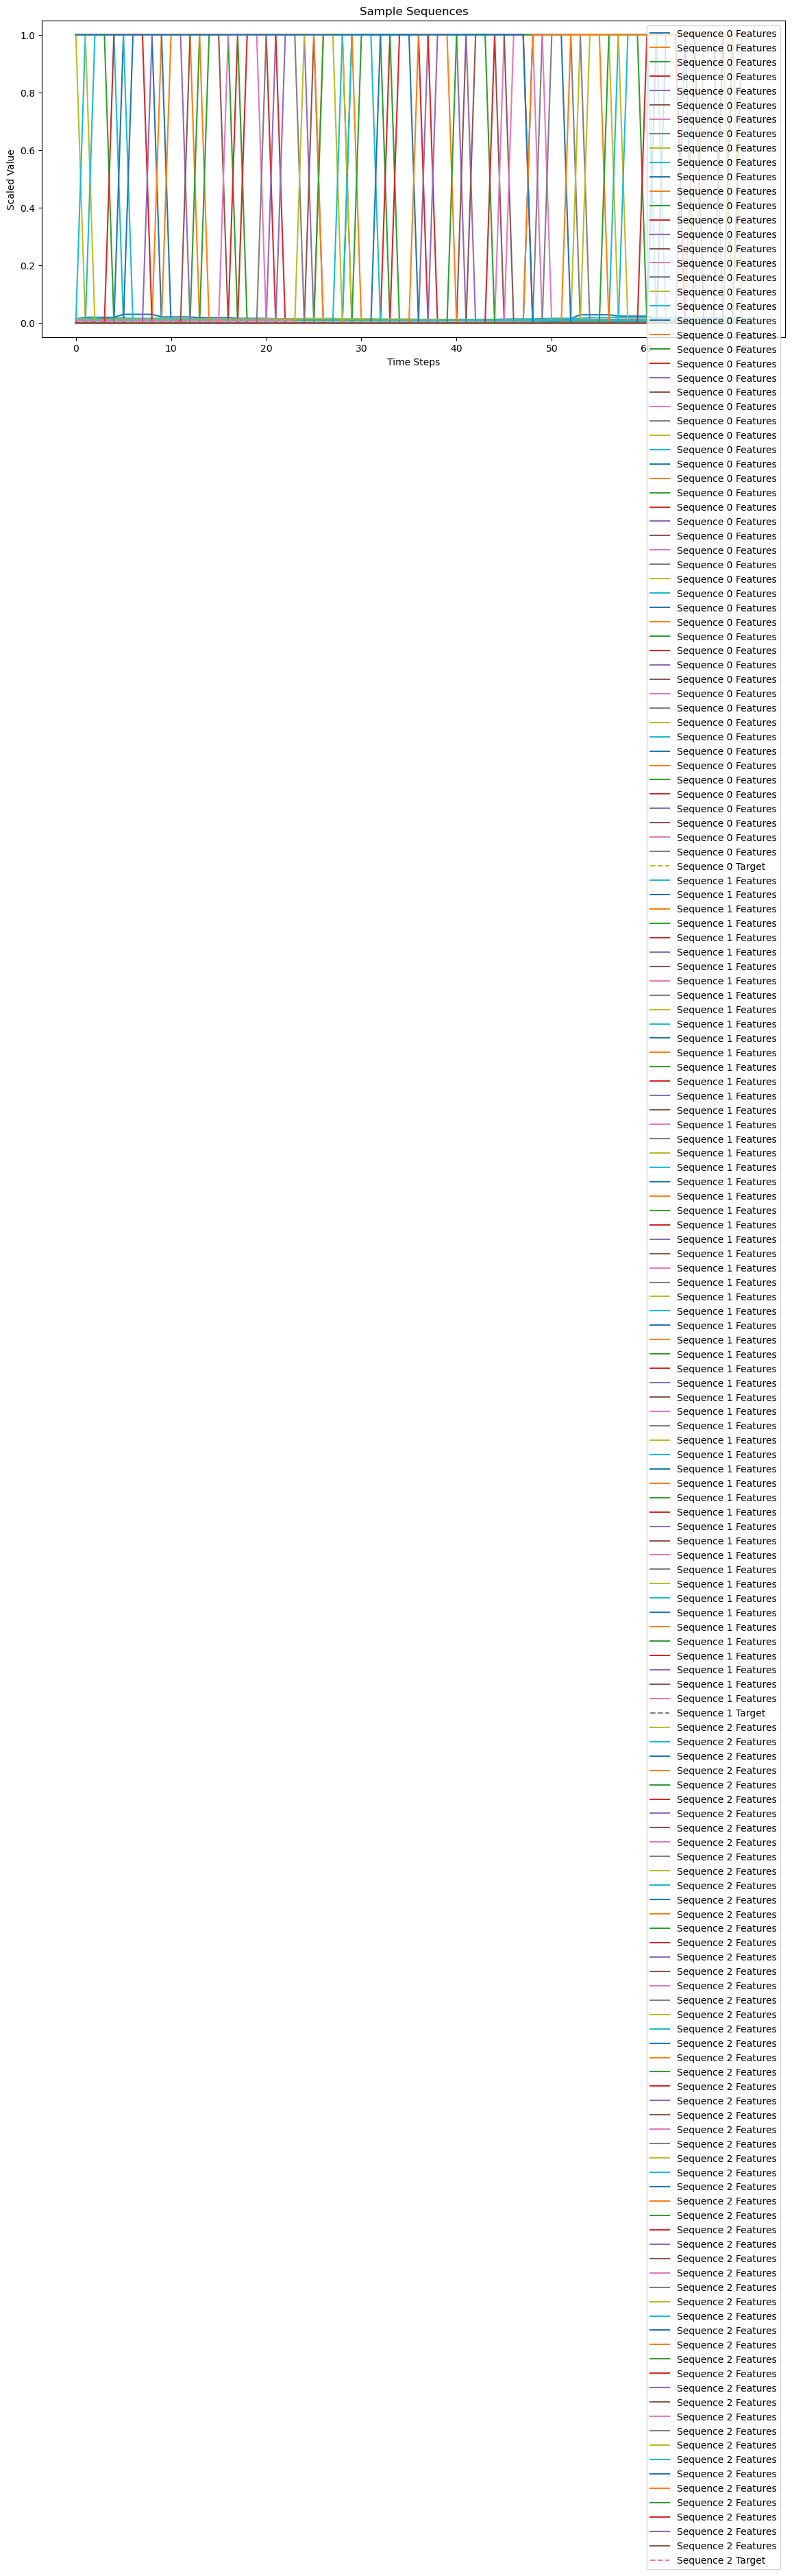

In [234]:
# Print shapes to verify
print("Train shapes: X =", X_train_scaled.shape, "y =", y_train_scaled.shape)
print("Validation shapes: X =", X_val_scaled.shape, "y =", y_val_scaled.shape)
print("Test shapes: X =", X_test_scaled.shape, "y =", y_test_scaled.shape)

# Optionally plot a few sequences
import matplotlib.pyplot as plt

def plot_sequences(X, y, title='Sample Sequences'):
    plt.figure(figsize=(14, 6))
    num_sequences = 3
    for i in range(num_sequences):
        plt.plot(X[i], label=f'Sequence {i} Features')
        plt.plot(y[i], label=f'Sequence {i} Target', linestyle='--')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.show()

plot_sequences(X_train_scaled[:3], y_train_scaled[:3])


In [240]:
# df_trimmed = trim_data(df)
# X, y, months = encode_data(df=df_trimmed)
# # Use the function to trim the data
# #X_trimmed, y_trimmed = trim_data(X, y)
# X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler_X, scaler_y = prep_LSTM_data(X=X, y=y, months=months)
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])  # (num_timesteps, num_features)

BiLSTM_3layers = Sequential()
BiLSTM_3layers.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh', kernel_regularizer=l2(0.01)), input_shape=input_shape))
BiLSTM_3layers.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh', kernel_regularizer=l2(0.01))))
BiLSTM_3layers.add(Bidirectional(LSTM(10, return_sequences=False, activation='tanh', kernel_regularizer=l2(0.01))))
BiLSTM_3layers.add(Dense(1))
BiLSTM_3layers.compile(optimizer='adam', loss='mse')
# Train model
#model_3.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)
# Train the model
history = BiLSTM_3layers.fit(X_train_scaled, y_train_scaled, epochs=30, batch_size=32, verbose=2, validation_data=(X_val_scaled, y_val_scaled))
# Save model
BiLSTM_3layers.save('model_BiLSTM_3layers.h5')


Epoch 1/30
661/661 - 411s - loss: 0.4359 - val_loss: 1.6091e-04 - 411s/epoch - 621ms/step
Epoch 2/30
661/661 - 460s - loss: 1.7530e-04 - val_loss: 1.6141e-04 - 460s/epoch - 696ms/step
Epoch 3/30
661/661 - 346s - loss: 1.7551e-04 - val_loss: 1.6125e-04 - 346s/epoch - 524ms/step
Epoch 4/30
661/661 - 345s - loss: 1.7532e-04 - val_loss: 1.6329e-04 - 345s/epoch - 521ms/step
Epoch 5/30
661/661 - 423s - loss: 1.7545e-04 - val_loss: 1.6278e-04 - 423s/epoch - 641ms/step
Epoch 6/30
661/661 - 403s - loss: 1.7543e-04 - val_loss: 1.6412e-04 - 403s/epoch - 610ms/step
Epoch 7/30
661/661 - 487s - loss: 1.7525e-04 - val_loss: 1.6093e-04 - 487s/epoch - 736ms/step
Epoch 8/30
661/661 - 353s - loss: 1.7554e-04 - val_loss: 1.6217e-04 - 353s/epoch - 534ms/step
Epoch 9/30
661/661 - 349s - loss: 1.7537e-04 - val_loss: 1.6126e-04 - 349s/epoch - 529ms/step
Epoch 10/30
661/661 - 350s - loss: 1.7519e-04 - val_loss: 1.6126e-04 - 350s/epoch - 530ms/step
Epoch 11/30
661/661 - 346s - loss: 1.7539e-04 - val_loss: 1.611

/Users/lesarmstrong/miniconda3/envs/1.c51-env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


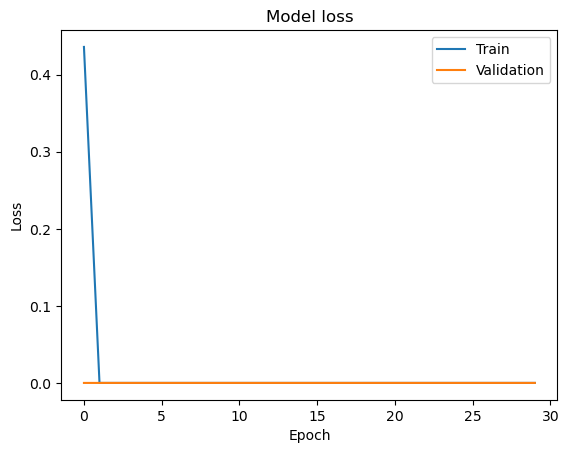

In [242]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# 

221/221 [==============================] - 41s 186ms/step
(7047, 288, 58)
(7047, 1)
(676512,)
(7047,)
[25.155783 25.155783 25.155783 ... 25.155783 25.155783 25.155783]


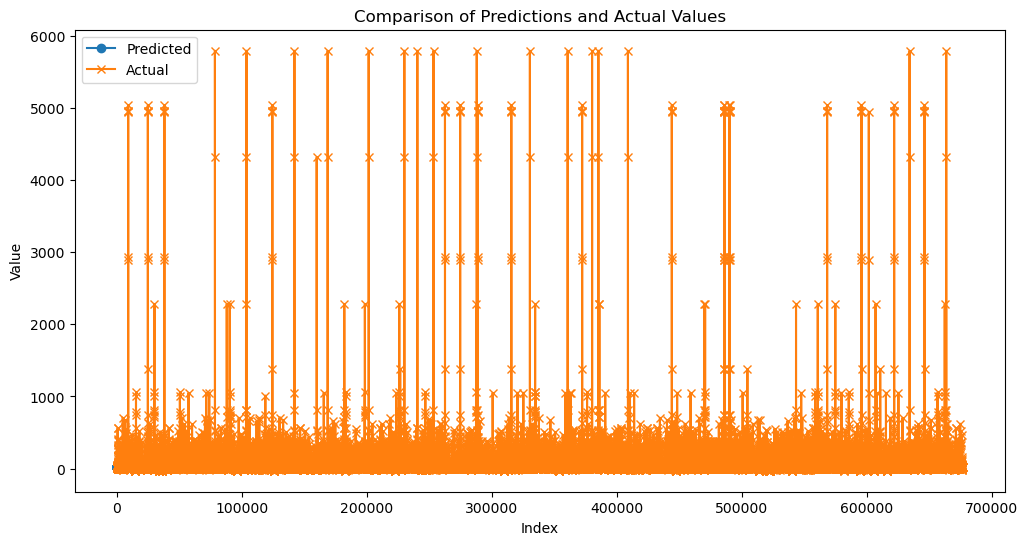

ValueError: operands could not be broadcast together with shapes (7047,) (676512,) 

<Figure size 1200x600 with 0 Axes>

In [245]:
y_pred_BiLST_3layers_scaled = BiLSTM_3layers.predict(X_test_scaled)
y_pred_BiLST_3layers = scaler_y.inverse_transform(y_pred_BiLST_3layers_scaled).flatten()
y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

print(X_test_scaled.shape)
print(y_pred_BiLST_3layers_scaled.shape)
print(y_test.shape)
print(y_pred_BiLST_3layers.shape)
print(y_pred_BiLST_3layers)
# Calculate the Mean Absolute Error
#mae_BiLSTM_3layers = mean_absolute_error(y_test, y_pred_BiLST_3layers)
#print(f'Mean Absolute Error: {mae_BiLSTM_3layers:.2f}')

# # Calculate the Mean Squared Error
# mse_BiLSTM_3layers = mean_squared_error(y_test, y_pred_BiLST_3layers)
# print(f'Mean Squared Error: {mse_BiLSTM_3layers:.2f}')

plot_comparison(y_pred_BiLST_3layers, y_test)

Troubleshooting:

Check the variance in your y_train to ensure there is enough variance to predict.

Try using a different activation function like 'tanh' or 'sigmoid'.

Experiment with different architectures, reducing the complexity of the model.

Scale back the L2 regularization (i.e., lower the lambda value).

Try different batch sizes and number of epochs.

Plot the training and validation loss to see if the model is learning over time.


In [168]:
X, y = encode_data(df=df)
# Use the function to trim the data
X_trimmed, y_trimmed = trim_data(X, y)
X_train, X_test, y_train, y_test, scaler_X, scaler_y = prep_LSTM_data(X=X_trimmed, y=y_trimmed)

# Make predictions
y_pred_3 = BiLSTM_3layers.predict(X_test)
# Flatten predictions and actual data
y_pred_3_flat = y_pred_3.reshape(-1)
y_test_flat = y_test.reshape(-1)

# In case these were not inverse transformed after prediction, do it here
y_pred_3_flat = scaler_y.inverse_transform(y_pred_3_flat.reshape(-1, 1)).flatten()
y_test_flat = scaler_y.inverse_transform(y_test_flat.reshape(-1, 1)).flatten()


# # Show accuracy
# mse = mean_squared_error(y_test_flat, y_pred_3_flat)
# rmse = np.sqrt(mse)
# print(f'Root Mean Squared Error: {rmse}')
# print(f'Accuracy: {100 - mse}%')

# Now you can call the plot_comparison function with properly formatted data
#plot_comparison(y_pred_3_flat, y_test_flat, startx=1700, endx=2000, starty=-10, endy=200)
X_train.shape

2/2 [==============================] - 0s 78ms/step


(148, 192, 57)

In [161]:
print(f"Shape of y_test: {y_test_flattened.shape}")
print(f"Shape of y_pred_3: {y_pred_3.shape}")


NameError: name 'y_test_flattened' is not defined

In [36]:
# Save model_3
BiLSTM_3layers.save('model_3.h5')

# Load model_3
from keras.models import load_model
BiLSTM_3layers = load_model('model_3.h5')


/Users/lesarmstrong/miniconda3/envs/1.c51-env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Seq2Seq

In [37]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout

In [98]:
# def create_sequences(X, y, input_length, prediction_length):
#     X_seq, y_seq = [], []
#     for i in range(len(X) - input_length - prediction_length + 1):
#         X_seq.append(X[i:(i + input_length)])
#         y_seq.append(y[(i + input_length):(i + input_length + prediction_length)])
#     return np.array(X_seq), np.array(y_seq)

# X, y = encode_data()

# input_seq_length = 48 * 4  # 48 hours with 15-minute intervals
# output_seq_length = 24 * 4  # 24 hours with 15-minute intervals

# X_sequences, y_sequences = create_sequences(X, y, input_seq_length, output_seq_length)
# y_sequences = y_sequences.reshape(y_sequences.shape[0], y_sequences.shape[1], 1)  # Reshaping for model compatibility

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)


### Model 3

input_seq_length: This should be the number of time steps you want your model to consider for each input sequence. It’s a hyperparameter you set based on your data or problem specifics.

output_seq_length: This is similar but for the output. For some sequence-to-sequence models, this might be the same as the input sequence length, or it might be different, such as when predicting future values or translating sentences to another language with different sentence lengths.

In [123]:
# X, y = encode_data()

# input_seq_length = 48 * 4  # 48 hours with 15-minute intervals
# output_seq_length = 24 * 4  # 24 hours with 15-minute intervals

# X_sequences, y_sequences = create_sequences(X, y, input_seq_length, output_seq_length)
# y_sequences = y_sequences.reshape(y_sequences.shape[0], y_sequences.shape[1], 1)  # Reshaping for model compatibility

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# X_train.shape[2]

57

In [120]:
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(28276, 192, 57) (7069, 192, 57) (28276, 96, 1) (7069, 96, 1)


In [ ]:
# df_trimmed = trim_data(df)
# X, y, months = encode_data(df=df_trimmed)
# # Use the function to trim the data
# #X_trimmed, y_trimmed = trim_data(X, y)
# X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler_X, scaler_y = prep_LSTM_data(X=X, y=y, months=months)
# input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])  # (num_timesteps, num_features)

In [ ]:

# Define input sequence length and the number of features
input_seq_length = autocorrelation_hours * intervals  # 
output_seq_length = 24 * intervals  # This should match the number of timesteps you want to predict
num_features = X_train_scaled.shape[1]  # Adjust this to match the second dimension of X_train after preprocessing

## SEQ2SEQ architecture

# Define the input shape for the encoder
encoder_inputs = Input(shape=(input_seq_length, num_features))

# Define the LSTM layers with dropout as you had previously set them up
encoder_lstm1 = LSTM(128, return_sequences=True, return_state=True, dropout=0.2)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)

encoder_lstm2 = LSTM(64, return_sequences=True, return_state=True, dropout=0.2)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

encoder_lstm3 = LSTM(32, return_state=True, dropout=0.2)
encoder_outputs3, state_h3, state_c3 = encoder_lstm3(encoder_outputs2)
encoder_states = [state_h3, state_c3]

# Define the decoder input and LSTM layer with dropout using the last encoder states as initial state
decoder_inputs = Input(shape=(output_seq_length, 1))  # Assuming the output feature is 1
decoder_lstm = LSTM(32, return_sequences=True, return_state=False, dropout=0.2)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Add a dropout layer after the LSTM layers
decoder_dropout = Dropout(0.2)(decoder_outputs)

# Define the dense output layer
decoder_dense = Dense(1, activation='linear')
decoder_outputs = decoder_dense(decoder_dropout)

# Define the Seq2Seq model that will turn `encoder_inputs` & `decoder_inputs` into `decoder_outputs`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 192, 57)]            0         []                            
                                                                                                  
 lstm_73 (LSTM)              [(None, 192, 128),           95232     ['input_31[0][0]']            
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                                  
 lstm_74 (LSTM)              [(None, 192, 64),            49408     ['lstm_73[0][0]']             
                              (None, 64),                                                  

In [ ]:
# Create a Zero-Padded Initial Input for the Decoder
decoder_input_train = np.zeros((y_train.shape[0], y_train.shape[1], 1))  # 
decoder_input_test = np.zeros((y_test.shape[0], y_test.shape[1], 1))  # 

history = model.fit(
    [X_train, decoder_input_train],  # Provide initial state for the decoder
    y_train,                         # Actual target outputs for training
    epochs=10,
    batch_size=64,
    validation_data=([X_test, decoder_input_test], y_test)  # Similar setup for validation
)


Epoch 1/10
442/442 [==============================] - 179s 381ms/step - loss: 5777.6396 - mae: 14.0405 - val_loss: 6221.1357 - val_mae: 9.7268
Epoch 2/10
442/442 [==============================] - 177s 400ms/step - loss: 5609.6436 - mae: 9.9086 - val_loss: 6186.1729 - val_mae: 10.2030
Epoch 3/10
442/442 [==============================] - 185s 418ms/step - loss: 5598.8970 - mae: 10.5413 - val_loss: 6184.3032 - val_mae: 10.7283
Epoch 4/10
442/442 [==============================] - 173s 391ms/step - loss: 5598.2153 - mae: 10.7657 - val_loss: 6184.2856 - val_mae: 10.7505
Epoch 5/10
442/442 [==============================] - 166s 376ms/step - loss: 5598.4697 - mae: 10.7884 - val_loss: 6184.3560 - val_mae: 10.6792
Epoch 6/10
442/442 [==============================] - 166s 375ms/step - loss: 5598.3394 - mae: 10.7045 - val_loss: 6184.2852 - val_mae: 10.9283
Epoch 7/10
442/442 [==============================] - 218s 495ms/step - loss: 5598.3228 - mae: 10.8359 - val_loss: 6184.3428 - val_mae: 10

In [ ]:
# Create the initial input for the decoder for prediction
decoder_input_test = np.zeros((y_test.shape[0], y_test.shape[1], 1))  # Assuming the same shape as during training

# Make predictions using the model
predictions = model.predict([X_test, decoder_input_test])

221/221 [==============================] - 21s 82ms/step


In [129]:
# Flatten the predictions and actual values if they are in three dimensions
predictions = predictions.reshape(-1)
actual = y_test.reshape(-1)


Mean Squared Error: 6192.209068663043
Mean Absolute Error: 9.436576292437172


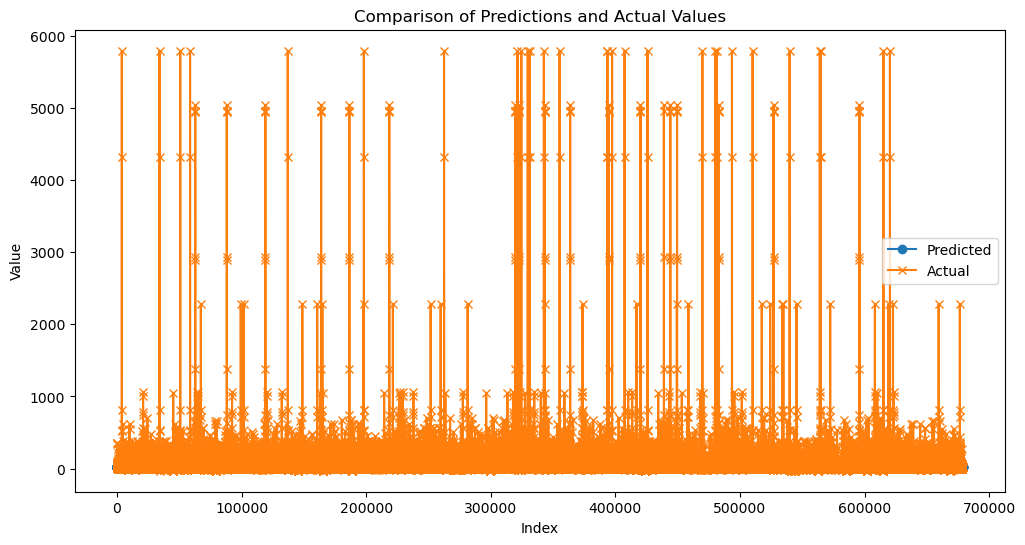

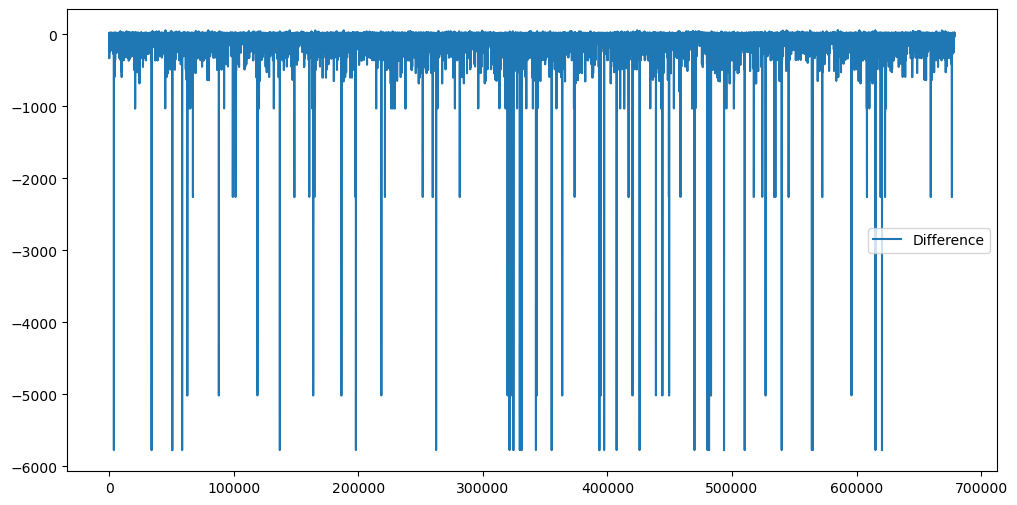

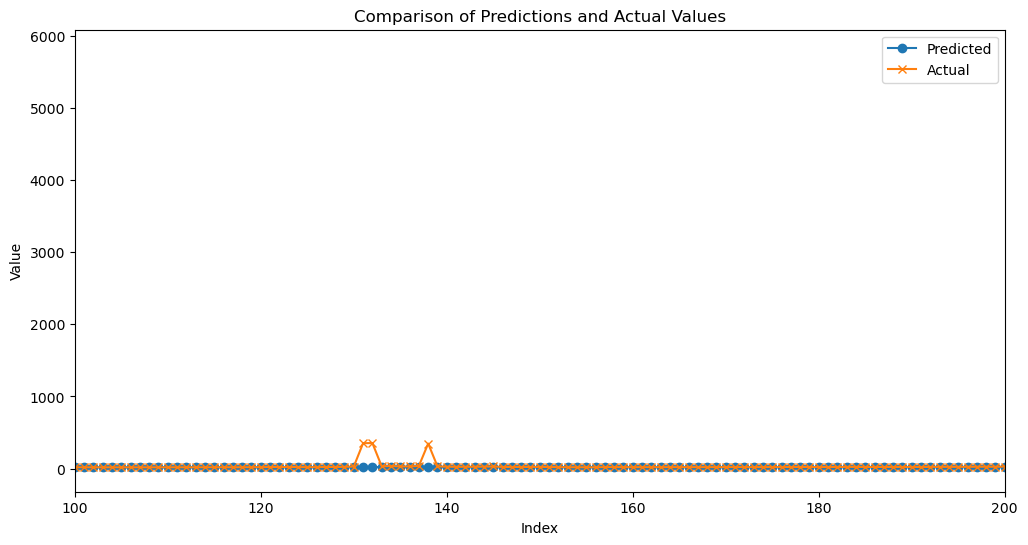

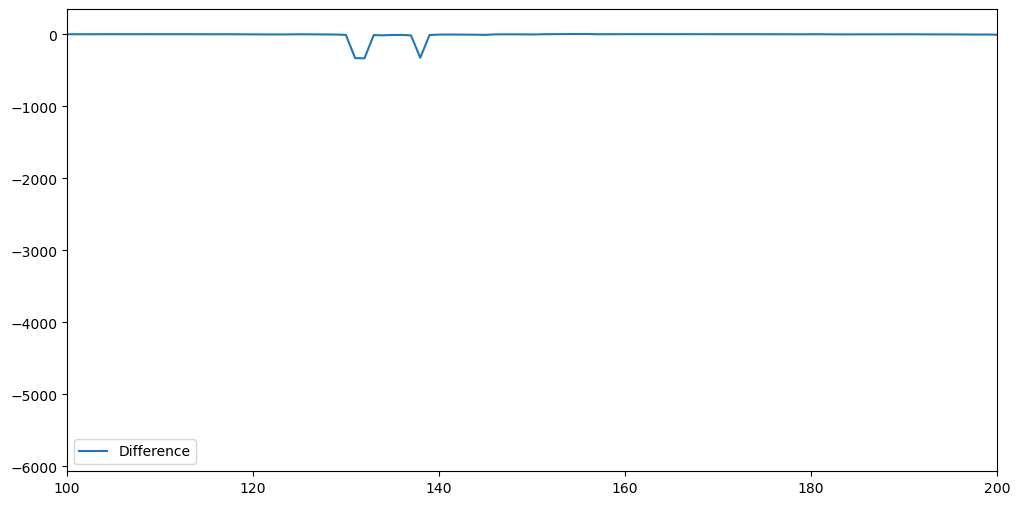

In [ ]:
mse = mean_squared_error(actual, predictions)
mae = mean_absolute_error(actual, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Plot the overall comparison
plot_comparison(predictions, actual)

# Plot a specific interval for detailed analysis
start_index = 100  # example start index
end_index = 200    # example end index
plot_comparison(predictions, actual, startx=start_index, endx=end_index)


## Bands

In [76]:
    y_test.shape

(7127, 1)